**Social Hackathon - Trajectory Analysis Part**



Step 1: Import the essential libraries.

In [ ]:
pip install tilemapbase

In [ ]:
import os
import sys
import datetime as dt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tilemapbase

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/gtheofilo/Ship-Stop-Points-Detection.git
sys.path.insert(0, '/content/Ship-Stop-Points-Detection')
from main import stop_points_based_segmentation, _haversine_np
from utilities import calculate_speed, calculate_distance, calculate_time_difference

Cloning into 'Ship-Stop-Points-Detection'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 52 (delta 22), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (52/52), 16.66 KiB | 897.00 KiB/s, done.


Step 2: Encoporate the dispersed trajectories from Microsoft's Geolife dataset into one dataframe.

In [ ]:
new_file = []
path = '/content/drive/My Drive/Colab Notebooks/Social Hackathon/Trajectory/plt'
saved_path = '/content/drive/My Drive/Colab Notebooks/Social Hackathon/Trajectory/csv'
i = 1
for filename in os.listdir(path):
   with open(os.path.join(path, filename), 'r') as f: 
      tmp = f.readlines()[6:]
      tmp = list(map(lambda s: str(i) + f',{s}', tmp))
      new_file.extend(tmp)
      i = i + 1

with open(os.path.join(saved_path, 'trajectories.csv'), 'w') as fp: 
      fp.writelines(new_file)

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Social Hackathon/Trajectory/csv/trajectories.csv', names=['id', 'lat', 'lon', 't', 'feet', 'since', 'date', 'timestamp'])
df = df.sort_values(by=['id', 'timestamp'])
df['timestamp'] = df['date'] + ' ' + df['timestamp']
df = df.drop(columns=['t', 'feet', 'since', 'date'])
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df['timestamp'] = (df['timestamp'] - dt.datetime(1970,1,1)).dt.total_seconds()
df['lon'] = df['lon'].astype('float')
df['lat'] = df['lat'].astype('float')
df = df.sort_values(by=['id', 'timestamp'])
df = df.groupby('id').apply(calculate_time_difference, timestamp='timestamp')
df = df.groupby('id').apply(calculate_distance, lon='lon', lat='lat')
df = df.groupby('id').apply(calculate_speed, time_diff='time_diff', dis_diff='dis_diff')

df['speed'] = df['speed'] * 3600

df = df.groupby('id', group_keys=False).filter(lambda s: s.speed.mean() < 7)
df = df.dropna().reset_index(drop=True)

df

<ipython-input-16-b64734852f90>:10: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby('id').apply(calculate_time_difference, timestamp='timestamp')
<ipython-input-16-b64734852f90>:11: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby('id').apply(calculate_distance, lon='l

,id,lat,lon,timestamp,time_diff,dis_diff,speed
0,4,39.999814,116.327284,1.240479e+09,5.0,0.002370,1.706281
1,4,39.999819,116.327270,1.240479e+09,5.0,0.001315,0.946753
2,4,39.999836,116.327277,1.240479e+09,5.0,0.001981,1.426233
3,4,39.999839,116.327366,1.240479e+09,5.0,0.007584,5.460215
4,4,39.999884,116.327394,1.240479e+09,5.0,0.005540,3.988542
...,...,...,...,...,...,...,...
217407,536,40.000329,116.327358,1.236250e+09,5.0,0.006840,4.925027
217408,536,40.000378,116.327309,1.236250e+09,5.0,0.006859,4.938606
217409,536,40.000434,116.327294,1.236250e+09,5.0,0.006353,4.573914
217410,536,40.000485,116.327239,1.236250e+09,5.0,0.007351,5.292846


In [ ]:
df = df.head(1000)

In [ ]:
df = stop_points_based_segmentation(df, identifier='id', speed_threshold=5.0, distance_threshold=0.02, time_threshold=180)

/content/Ship-Stop-Points-Detection/main.py:114: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _next = grp_copy.iloc[ri + 1:][grp_copy['speed'] > speed_threshold]['timestamp'].idxmin()
/content/Ship-Stop-Points-Detection/main.py:115: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  slow_speed_points = grp_copy.iloc[_next:][grp_copy['speed'] <= speed_threshold].index
/content/Ship-Stop-Points-Detection/main.py:114: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _next = grp_copy.iloc[ri + 1:][grp_copy['speed'] > speed_threshold]['timestamp'].idxmin()
/content/Ship-Stop-Points-Detection/main.py:130: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if grp_copy.iloc[:stop_points[0]][grp_copy['speed'] > speed_threshold]['timestamp'].empty:
/content/Ship-Stop-Points-Detection/main.py:133: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  last_che

In [ ]:
tilemapbase.init(create=True)
expand=0.001
extent = tilemapbase.Extent.from_lonlat(
    df.lon.min() - expand,
    df.lon.max() + expand,
    df.lat.min() - expand,
    df.lat.max() + expand,
)

trip_projected = df.apply(
    lambda x: tilemapbase.project(x.lon, x.lat), axis=1
).apply(pd.Series)
trip_projected.columns = ["x", "y"]

tiles = tilemapbase.tiles.build_OSM()

(0.8231068277777777,
 0.823136913888889,
 0.37860564521391454,
 0.3785412109946623)

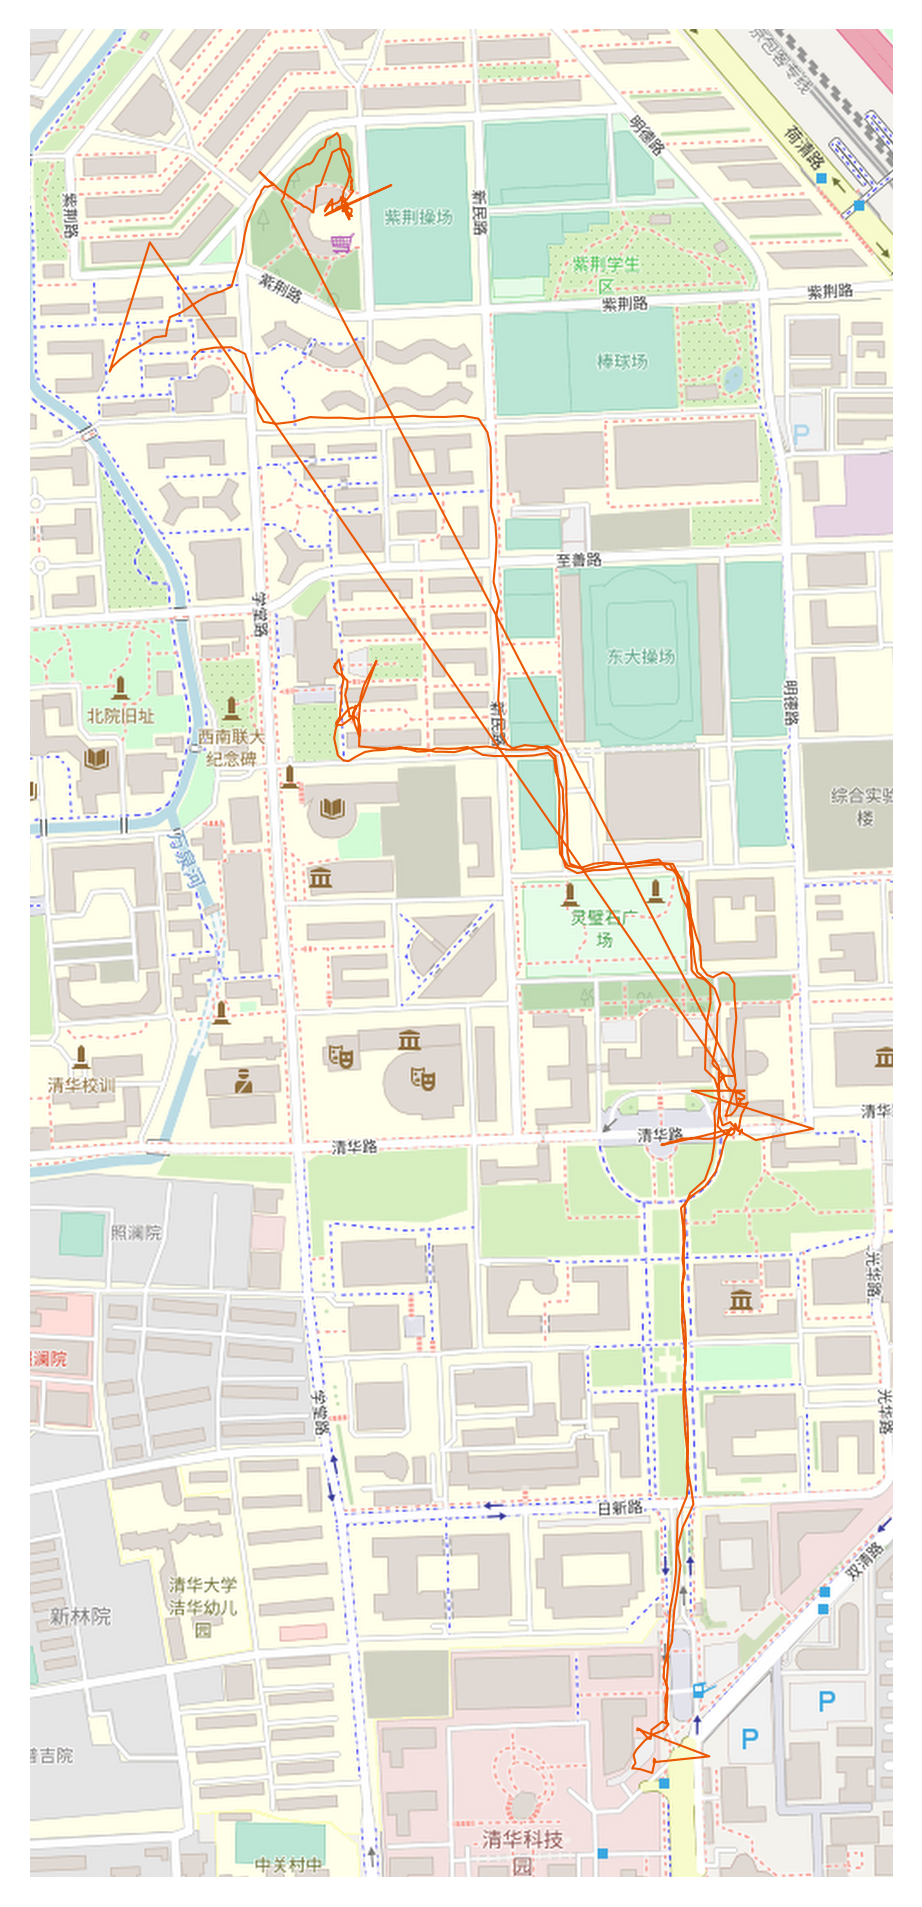

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plotter = tilemapbase.Plotter(extent, tiles, height=600)
plotter.plot(ax, tiles, alpha=0.8)
ax.plot(trip_projected.x, trip_projected.y, color='#eb5600', linewidth=0.5)
plt.axis('off')